In [2]:
import pandas as pd
import numpy as np
import sklearn
import imblearn
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_validate

In [3]:
data = pd.read_csv("../Datasets/Train_dataset.csv")

In [4]:
# data = data[['smart_12_normalized', 'smart_189_normalized', 'smart_190_normalized', 'smart_193_normalized',
#              'smart_199_normalized', 'smart_240_normalized', 'smart_242_normalized', 'smart_5_normalized',
#              'smart_187_normalized', 'smart_188_normalized', 'smart_197_normalized', 'smart_198_normalized',
#              'failure_actual_fail']]
data.drop(columns = ['date_x','serial_number','model','failure_x','date_actual_fail'], inplace=True)

C:\Users\quant\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='failure_actual_fail', ylabel='count'>

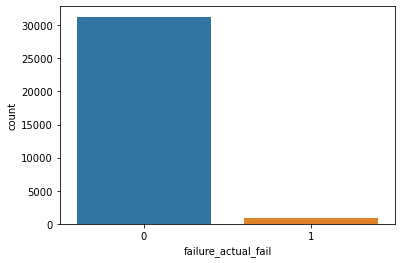

In [5]:
sns.countplot(data['failure_actual_fail'])

In [6]:
x = data.drop(columns="failure_actual_fail")
y = data[['failure_actual_fail']]
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.2, random_state=7)

In [7]:
smtomek = SMOTETomek()
x_train, y_train = smtomek.fit_resample(x_train, y_train)
# oversample = SMOTE()
# x_train, y_train = oversample.fit_resample(x_train, y_train)
# undersample = RandomUnderSampler()
# x_train, y_train = undersample.fit_resample(x_train, y_train)
total_train = pd.concat([x_train, y_train], axis=1)

In [8]:
positives = total_train[total_train['failure_actual_fail'] == 1]
negatives = total_train[total_train['failure_actual_fail'] == 0]
negatives = negatives.sample(frac=0.2, random_state=1)
total_train = pd.concat([positives, negatives])
x_train = total_train.drop(columns='failure_actual_fail')
y_train = total_train[['failure_actual_fail']]

C:\Users\quant\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='failure_actual_fail', ylabel='count'>

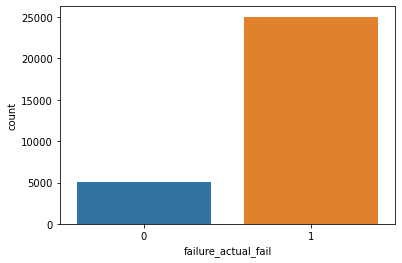

In [9]:
sns.countplot(y_train['failure_actual_fail'])

In [10]:
# Hyperparameters:
# n-estimators: [10, 2000] increments of 10 or 100?
# learning rate [0.1, 2.0], increments of 0.1
# Base estimator: logistic regression

n_estimators = 1000
clf = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=1.4)
# scores = cross_val_score(clf, x_train, y_train, cv=5)
# scores.mean()
clf.fit(x_train, y_train)

C:\Users\quant\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(learning_rate=1.4, n_estimators=1000)

In [11]:
predictions = clf.predict(x_test)

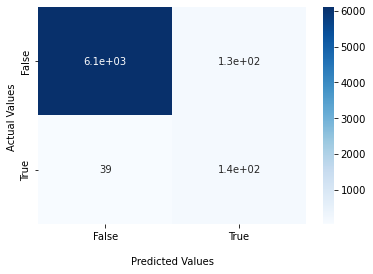

In [12]:
cf_matrix = confusion_matrix(y_test, predictions)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [13]:
conf_mat = confusion_matrix(y_test, predictions)

In [14]:
precision_score = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[0][1])
recall_score = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0])
print(f"Precision: {precision_score}")
print(f"Recall: {recall_score}")

Precision: 0.5055350553505535
Recall: 0.7784090909090909


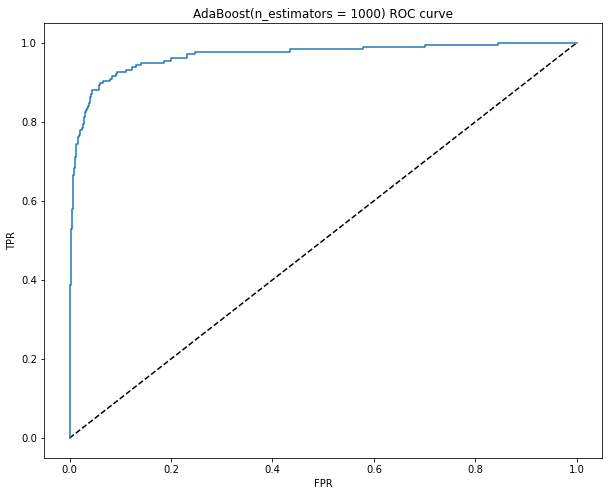

In [15]:
y_pred_proba = clf.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize = (10,8))
plt.plot([0, 1], [0.0, 1.0],'k--')
plt.plot(fpr, tpr, label = 'Ada')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'AdaBoost(n_estimators = {n_estimators}) ROC curve')
plt.show()

In [16]:
roc_auc = roc_auc_score(y_test, y_pred_proba) # TRY TO MAXIMISE
print(roc_auc)

0.966493007552716


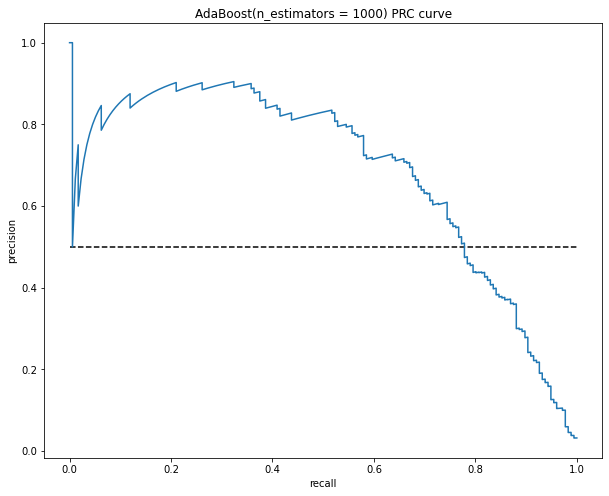

In [17]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize = (10,8))
plt.plot([0, 1], [0.5, 0.5],'k--')
plt.plot(recall, precision, label = 'Ada')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title(f'AdaBoost(n_estimators = {n_estimators}) PRC curve')
plt.show()

In [18]:
auc_prc = auc(recall, precision) # TRY TO MAXIMISE
print(auc_prc)

0.6818138252107909


In [19]:
nb_various = cross_validate(clf, x_train, np.ravel(y_train), scoring=['recall','precision'], cv=8)
test_recall = nb_various['test_recall']
test_precision = nb_various['test_precision']

In [20]:
test_recall_ave = sum(test_recall) / len(test_recall)
print(f"Recall average: {test_recall_ave}")
test_precision_ave = sum(test_precision) / len(test_precision)
print(f"Precision average: {test_precision_ave}")

Recall average: 0.9785474337094044
Precision average: 0.9956276331731709


In [21]:
clf.score(x_test, y_test)

0.973065545695158

Using Test_dataset.csv

In [22]:
testing_data = pd.read_csv("../Datasets/Test_dataset.csv")
testing_data.drop(columns = ['date_x','serial_number','model','failure_x','date_actual_fail', 'new_date'], inplace=True)

In [23]:
testing_x = testing_data.drop(columns="failure_actual_fail")
testing_y = testing_data[['failure_actual_fail']]

In [24]:
testing_predictions = clf.predict(testing_x)
clf.score(testing_x, testing_y)

0.9511097314915412

In [25]:
conf_mat = confusion_matrix(testing_y, testing_predictions)
print(conf_mat)

[[18335   876]
 [   69    49]]


In [26]:
precision_score = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[0][1])
recall_score = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0])
print(f"Precision: {precision_score}")
print(f"Recall: {recall_score}")

Precision: 0.05297297297297297
Recall: 0.4152542372881356
